# **Crop Disease Detection using CNNs**

### **Artificial Intelligence Project**
**Topic:** Crop Disease Detection (Tomato Leaf Disease)

---
### **Team Members**
* **Ahmed Sameer Hashemi** (66026)
* **Ayaan Waheed** (66344)

**Presented to:** Mr. Junaid Khan

---

### **1. Introduction & Problem Statement**
Plant diseases significantly affect crop yield and quality, with tomato plants being particularly vulnerable to various fungal, bacterial, and viral infections. Manual identification is time-consuming and error-prone.

**Objective:**
This project aims to develop a deep learning-based image classification system using **Convolutional Neural Networks (CNNs)**—specifically **EfficientNetB0**—to detect and classify tomato leaf diseases automatically.

**Dataset:**
We are using the **PlantVillage Tomato Leaf Dataset**, which consists of 10 classes (8 diseases + 1 viral + healthy).

In [4]:
# Install required packages
!pip install -q kagglehub tensorflow matplotlib seaborn scikit-learn

import os
import kagglehub
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
# CRITICAL: EfficientNet expects specific preprocessing, not just /255
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


### **2. Setup and Dependencies**
We start by installing necessary libraries including `kagglehub` for data downloading and `tensorflow` for building the model. [cite_start]We also import `matplotlib` and `seaborn` for visualization[cite: 39].

In [5]:
# Download dataset
path = kagglehub.dataset_download("kaustubhb999/tomatoleaf")
print("Dataset base path:", path)

100%|██████████| 179M/179M [00:08<00:00, 21.1MB/s]

Extracting files...


Dataset base path: /root/.cache/kagglehub/datasets/kaustubhb999/tomatoleaf/versions/1


### **3. Data Preprocessing & Augmentation**
[cite_start]To ensure our model generalizes well and avoids overfitting, we apply the following preprocessing steps[cite: 27]:
* **Resizing:** All images are resized to **224x224** pixels to match EfficientNetB0 input requirements.
* **Preprocessing:** We use `preprocess_input` to normalize pixel values specifically for the EfficientNet architecture.
* **Augmentation:** We apply rotation, zooming, and shifting to the training data to simulate real-world variations.

In [6]:
# Locate the actual dataset directory
# We look for the folder that contains 'train' and 'val' subfolders
dataset_root = None

for root, dirs, files in os.walk(path):
    if 'train' in dirs and 'val' in dirs:
        dataset_root = root
        break

if dataset_root is None:
    # Fallback if structure is different, usually it's inside 'tomato'
    dataset_root = os.path.join(path, 'tomato')

train_dir = os.path.join(dataset_root, 'train')
val_dir = os.path.join(dataset_root, 'val')

print(f"Training data located at: {train_dir}")
print(f"Validation data located at: {val_dir}")

# Verify we see the 10 disease classes
if os.path.exists(train_dir):
    print(f"Classes found: {len(os.listdir(train_dir))}")
    print("Example classes:", os.listdir(train_dir)[:5])
else:
    print("ERROR: Could not locate train directory. Please check the path manually.")

Training data located at: /root/.cache/kagglehub/datasets/kaustubhb999/tomatoleaf/versions/1/tomato/train
Validation data located at: /root/.cache/kagglehub/datasets/kaustubhb999/tomatoleaf/versions/1/tomato/val
Classes found: 10
Example classes: ['Tomato___Septoria_leaf_spot', 'Tomato___Target_Spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Bacterial_spot']


### **4. Model Architecture: EfficientNetB0**
We utilize **Transfer Learning** with the **EfficientNetB0** architecture pre-trained on ImageNet.

**Methodology:**
1.  **Feature Extractor:** We use EfficientNetB0 as the base, removing the top layers (`include_top=False`).
2.  **Fine-Tuning:** We unfreeze the top 20 layers of the base model to allow it to learn specific features of tomato leaves, while keeping the bottom layers frozen to retain generic edge/texture detection.
3.  **Custom Head:** We add a Global Average Pooling layer, a Dropout layer (to prevent overfitting), and a final Dense layer with Softmax activation for the 10-class classification.

In [7]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Training Generator with Augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, # Match EfficientNet requirements
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation Generator (No augmentation, just preprocessing)
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Flow from directory
print("Loading Training Data:")
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

print("\nLoading Validation Data:")
val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # Important for Confusion Matrix later
)

class_names = list(train_gen.class_indices.keys())
print(f"\nDetected Classes: {class_names}")

Loading Training Data:
Found 10000 images belonging to 10 classes.

Loading Validation Data:
Found 1000 images belonging to 10 classes.

Detected Classes: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


In [8]:
# 1. Load Base Model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 2. Fine-tuning: Unfreeze the top layers
base_model.trainable = True
# Freeze the bottom layers (keep generic features like edges/textures)
# Unfreeze the top 20 layers (learn specific leaf diseases)
for layer in base_model.layers[:-20]:
    layer.trainable = False

# 3. Add Custom Head
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False) # Keep BatchNorm in inference mode
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x) # Higher dropout for fine-tuning
outputs = layers.Dense(len(class_names), activation='softmax')(x)

model = models.Model(inputs, outputs)

# 4. Compile with a lower learning rate for stability
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), # Low LR is safer for unfreezing
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,062,381 (15.50 MB)

 Trainable params: 1,363,770 (5.20 MB)

 Non-trainable params: 2,698,611 (10.29 MB)

### **5. Training**
The model is trained using the **Adam optimizer** and **categorical cross-entropy loss**.

To optimize performance, we implement:
* **EarlyStopping:** Stops training if validation loss stops improving.
* **ReduceLROnPlateau:** Lowers the learning rate if the model gets stuck, helping it converge to a better solution.
* **ModelCheckpoint:** Saves the best version of the model during training.

In [9]:
# Callbacks to save the best model and prevent wasting time
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint('best_tomato_model.keras', monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=1e-6)
]

history = model.fit(
    train_gen,
    epochs=20, # Higher epoch count, EarlyStopping will stop it if needed
    validation_data=val_gen,
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.4560 - loss: 1.6607
Epoch 1: val_loss improved from inf to 0.56111, saving model to best_tomato_model.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 200s 510ms/step - accuracy: 0.4566 - loss: 1.6592 - val_accuracy: 0.8200 - val_loss: 0.5611 - learning_rate: 1.0000e-04
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.8514 - loss: 0.5050
Epoch 2: val_loss improved from 0.56111 to 0.30063, saving model to best_tomato_model.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 123s 392ms/step - accuracy: 0.8514 - loss: 0.5048 - val_accuracy: 0.9090 - val_loss: 0.3006 - learning_rate: 1.0000e-04
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.8981 - loss: 0.3152
Epoch 3: val_loss improved from 0.30063 to 0.25544, saving model to best_tomato_model.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 122s 390ms/step - accuracy: 0.8981 - loss: 0.3151 - val_accuracy: 0.9160 - val_loss: 0.2554 - learning_rate: 1.0000e-04
Epoch 4/20
313/31

### **6. Evaluation & Results**
We evaluate the model's performance using Accuracy and Loss curves. Additionally, we generate a **Confusion Matrix** to visualize how well the model distinguishes between different diseases (e.g., Bacterial Spot vs. Early Blight).

**Target Goal:** Achieve validation accuracy above 90%.

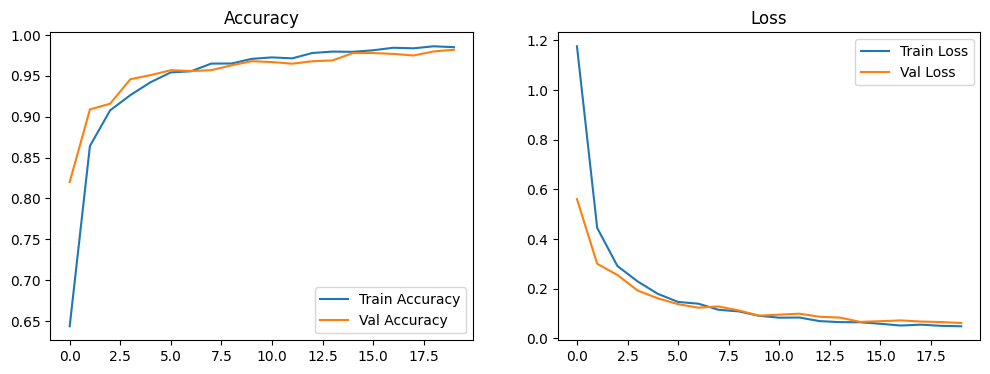

32/32 ━━━━━━━━━━━━━━━━━━━━ 25s 358ms/step


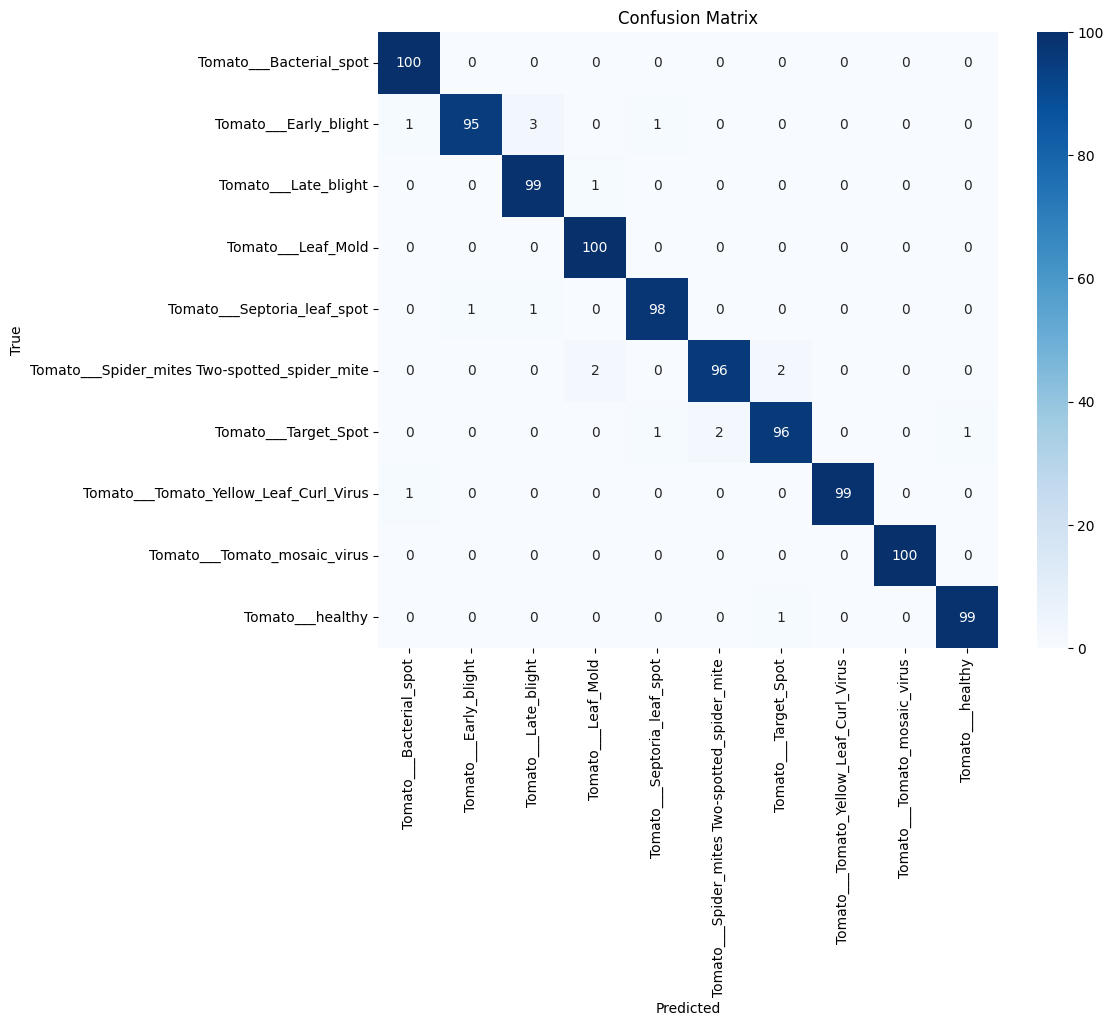

In [10]:
# Accuracy Graphs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

# Confusion Matrix
Y_pred = model.predict(val_gen)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_gen.classes

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### **7. Real-world Testing**
In this section, we simulate a real-world application where a user (e.g., a farmer) uploads an image of a tomato leaf. The model processes the image and outputs the diagnosis along with a confidence score.

Saving 0a0d6a11-ddd6-4dac-8469-d5f65af5afca___RS_HL 0555.JPG to 0a0d6a11-ddd6-4dac-8469-d5f65af5afca___RS_HL 0555.JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


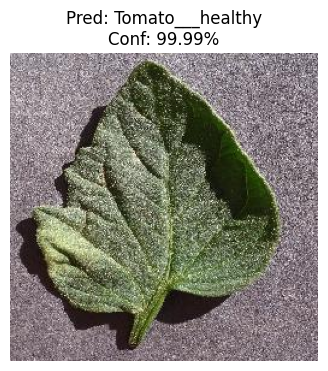

In [11]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf  # <--- Added this to fix your 'tf' error

# Upload the file
uploaded = files.upload()

for filename in uploaded.keys():
    try:
        # 1. Load and preprocess image
        img = image.load_img(filename, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)

        # CRITICAL: Use the same preprocessing as training
        # We use the efficientnet preprocess_input function
        img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

        # 2. Predict
        prediction = model.predict(img_array)
        predicted_index = np.argmax(prediction)

        # Ensure class_names is available.
        # If 'class_names' is missing (e.g. cell run in isolation), we handle it safely.
        if 'class_names' in locals():
            predicted_class = class_names[predicted_index]
        else:
            # Fallback if you haven't run the training cell recently
            predicted_class = f"Class Index {predicted_index} (Run Cell 4 to load names)"

        confidence = np.max(prediction) * 100

        # 3. Display Result
        plt.figure(figsize=(4, 4))
        plt.imshow(image.load_img(filename)) # Show original image
        plt.axis('off')
        plt.title(f"Pred: {predicted_class}\nConf: {confidence:.2f}%")
        plt.show()

    except Exception as e:
        print(f"Error processing {filename}: {e}")
        print("Tip: Make sure you have run 'Cell 5' (Build Model) so the 'model' variable is active!")